In [1]:
## Keras configuration

# Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

# Load Keras
import keras

# Load the libraries
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using Theano backend.


In [2]:
import pandas as pd
from functools import reduce

In [3]:
# Load Data into array

nodes = []
for x in range(0, 3):
    nodes.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n' + str(x+150) +'.dat',
                     error_bad_lines=False, header=1))
    print("Loaded file MDA300n"+str(x+150)+".dat")

Loaded file MDA300n150.dat
Loaded file MDA300n151.dat
Loaded file MDA300n152.dat


In [4]:
# Split TimeStamp into Date and Time columns and 

numNodes = len(nodes)
for y in range(numNodes):
    nodes[y][['DATE','TIME']] = nodes[y].TMSTAMP.str.split(expand=True)
    nodes[y].TIME = nodes[y].TIME.str[0:5] + ':00'

In [5]:
for w in range(numNodes):
    nodes[w] = nodes[w].drop('TMSTAMP', 1)
    nodes[w] = nodes[w].drop('RECNBR', 1)
    nodes[w] = nodes[w].drop('PARENT', 1)
    nodes[w] = nodes[w].drop('SOLAROCV', 1)
    nodes[w] = nodes[w].drop('VBATT', 1)
    nodes[w] = nodes[w].drop('TEMP', 1)
    nodes[w] = nodes[w].drop('DATE', 1)

In [6]:
dataR = reduce(lambda  left,right: pd.merge(left,right,on=['IRRADIANCE','TIME'],how='outer'), nodes)

In [7]:
dataR = dataR.groupby('TIME').mean().reset_index()

In [8]:
dataR.sort_values(by='TIME')

,TIME,IRRADIANCE
0,00:00:00,13.134230
1,00:01:00,15.638665
2,00:02:00,28.817829
3,00:03:00,12.005140
4,00:04:00,21.816436
5,00:05:00,19.551621
6,00:06:00,13.848006
7,00:07:00,21.530526
8,00:08:00,10.180501
9,00:09:00,20.976130


In [9]:
import sklearn
from sklearn.model_selection import train_test_split

# dataR = reduce(lambda  left,right: pd.merge(left,right,on=['IRRADIANCE','TIME'],how='outer'), nodes)
# dataR.TIME = pd.to_datetime(dataR.TIME)
Train_Set_R = dataR

In [10]:
# Training set only consists of irradiance values ordered by timestamp
trainset_order = Train_Set_R.sort_values(by='TIME')

In [11]:
# Remove Time, retain Irradiance only
train_R = trainset_order.iloc[:, 1:2].values

In [12]:
train_R

array([[13.13422966],
       [15.63866486],
       [28.81782875],
       ...,
       [28.20131206],
       [15.3887876 ],
       [18.93142943]])

In [13]:
# Data Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

In [14]:
# Scale the training set
train_scaled = scaler.fit_transform(train_R)

In [15]:
# Feature variable: Irradiance values over the previous 60 minutes
# Label (to be predicted): Irradiance of the next minute (61st min)

features_set = []
labels = []
numRec = len(train_scaled)

for i in range(60, numRec):
    features_set.append(train_scaled[i-60:i,0])
    labels.append(train_scaled[i,0])

In [17]:
# Re-shaping the training set to numpy array before feeding the model

features_set, labels = np.array(features_set), np.array(labels)

features_set = np.reshape(features_set,(features_set.shape[0],features_set.shape[1],1))

In [18]:
features_set.shape

(1380, 60, 1)

In [19]:
from keras.layers import Dense
from keras.layers import LSTM

modelM = Sequential()
modelM.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
modelM.add(LSTM(units=50, return_sequences=True))
modelM.add(Dropout(0.2))

modelM.add(LSTM(units=50, return_sequences=True))
modelM.add(Dropout(0.2))

modelM.add(LSTM(units=50))
modelM.add(Dropout(0.2))

In [20]:
modelM.add(Dense(units = 1))
modelM.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
historyM = modelM.fit(features_set, labels, epochs = 5, batch_size = 128)

Epoch 1/5
1380/1380 [==============================] - 5s 3ms/step - loss: 0.0870
Epoch 2/5
1380/1380 [==============================] - 5s 3ms/step - loss: 0.0181
Epoch 3/5
1380/1380 [==============================] - 5s 4ms/step - loss: 0.0119
Epoch 4/5
1380/1380 [==============================] - 6s 5ms/step - loss: 0.0097
Epoch 5/5
1380/1380 [==============================] - 5s 4ms/step - loss: 0.0081


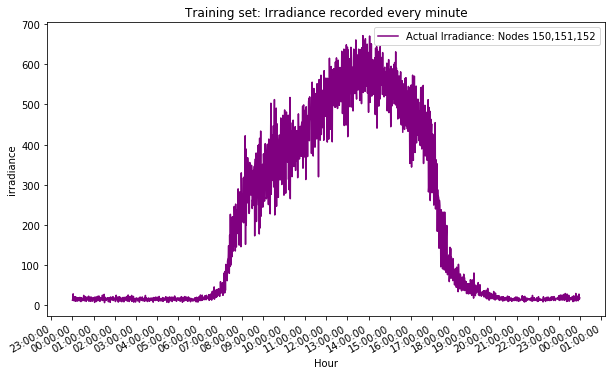

In [67]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

x = pd.to_datetime(dataR.TIME)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, dataR.IRRADIANCE, color='purple', label='Actual Irradiance: Nodes 150,151,152')
ax.set(xlabel="Hour", ylabel="irradiance",
       title="Actual Irradiance")

# Format the x axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.legend()
plt.title('Training set: Irradiance recorded every minute')

fig.autofmt_xdate()
plt.show()

### Prediction with data from Node 154

In [51]:
test_input = []
test_input.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n154.dat',
                     error_bad_lines=False, header=1))
print("Loaded file MDA300n154.dat")

Loaded file MDA300n154.dat


In [52]:
test_input[0][['DATE','TIME']] = test_input[0].TMSTAMP.str.split(expand=True)
test_input[0].TIME = test_input[0].TIME.str[0:5] + ':00'

In [53]:
test_input = test_input[0]
len(test_input)

67808

In [54]:
test_input = test_input.drop('TMSTAMP', 1)
test_input = test_input.drop('RECNBR', 1)
test_input = test_input.drop('PARENT', 1)
test_input = test_input.drop('SOLAROCV', 1)
test_input = test_input.drop('VBATT', 1)
test_input = test_input.drop('TEMP', 1)
test_input = test_input.drop('DATE', 1)

In [55]:
# Drop duplicates
# test_input.drop_duplicates(subset='TIME',keep='first',inplace=True)
# Re-order
test_input = test_input.groupby('TIME').mean().reset_index()
test_input = test_input.sort_values(by='TIME')

In [56]:
# Testing set contains recorded irradiance values 

testset = test_input.iloc[:, 1:2].values

In [57]:
testset

array([[3.17],
       [3.17],
       [3.17],
       ...,
       [3.17],
       [3.17],
       [3.17]])

In [60]:
# Transform testing set
testset = testset.reshape(-1,1)
testset = scaler.transform(testset)

In [61]:
# Feed the model with irradiance values recorded every minute

test_features = []
num = len(testset)

for i in range(60, num):
    test_features.append(testset[i-60:i, 0])

In [62]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [63]:
predictions = modelM.predict(test_features)

In [64]:
# Inverse transform the prediction because inputs are scaled

predictions = scaler.inverse_transform(predictions)

In [65]:
predictions

array([[1.4719185],
       [1.4719185],
       [1.4719185],
       ...,
       [1.4719185],
       [1.4719185],
       [1.4719185]], dtype=float32)

In [89]:
predictions.shape

(1380, 1)

In [103]:
test_input.TIME[60:62]

60    01:00:00
61    01:01:00
Name: TIME, dtype: object

In [105]:
x2 = test_input.TIME[60:1441]
x2.shape

(1380,)

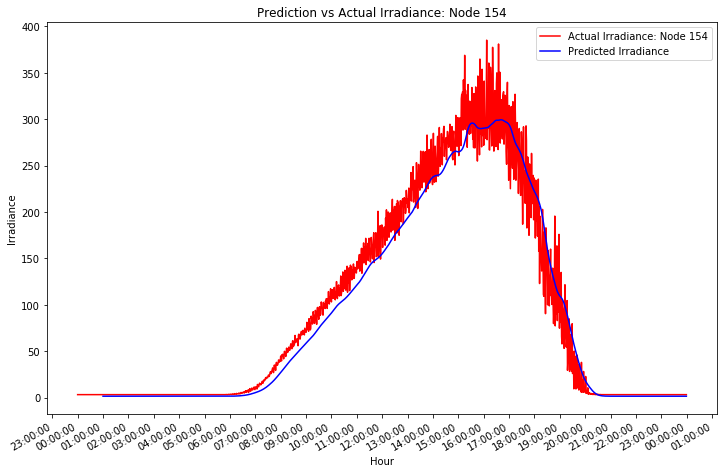

In [114]:
x = pd.to_datetime(test_input.TIME)
x2 = pd.to_datetime(x2)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, test_input.IRRADIANCE, color='red', label='Actual Irradiance: Node 154')
ax.plot(x2, predictions, color='blue', label='Predicted Irradiance')
ax.set(xlabel="Hour", ylabel="Irradiance")

# Format the x axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.legend()
plt.title('Prediction vs Actual Irradiance: Node 154')

fig.autofmt_xdate()
plt.show()